Stock price prediction using LTSM RNN. 

Dataset : https://www.nseindia.com/get-quotes/equity?symbol=GRASIM

Aggregated data file (NSE_GRASIM.CSV) : https://drive.google.com/file/d/1LwV-mxmGGgHyMSkZqMkir5k13JCX_OcX/view?usp=sharing

Tutorial : https://www.section.io/engineering-education/stock-price-prediction-using-python/

Python imports needed to run the code

Numpy - Numerical operations on the data
Pandas - To work on the dataset as a dataframe
matplotlib - For data visualization
sklearn - for data scaling
keras - to build our machine learning model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

Since google colab is hosted environment we have to upload the dataset from our local machine using the below code.

The data file name is NSE_GRASIM.CSV
Upload the above file.

In [ ]:
from google.colab import files
dataset = files.upload()

Saving NSE_RELIANCE.csv to NSE_RELIANCE (2).csv


Now we will load this file into a pandas dataframe. Dataframe helps us to transform the data according to our requirements. 

In [ ]:
df = pd.read_csv('NSE_RELIANCE.csv')

df.shape will give us the shape (size) of the dataset. here (1239,14) denotes 1239 rows and 14 columns.

In [ ]:
df.shape

(1390, 14)

In [ ]:
df.head()

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,29-Dec-17,EQ,926.50,932.3,918.50,924.20,920.10,921.05,924.13,1664.9,779.1,5069838.0,4.685185e+09,102691.0
1,28-Dec-17,EQ,925.25,934.4,919.10,923.75,922.60,924.20,924.83,1664.9,779.1,7091515.0,6.558468e+09,92078.0
2,27-Dec-17,EQ,933.00,937.5,919.00,929.80,923.25,923.75,930.28,1664.9,779.1,4352384.0,4.048927e+09,107845.0
3,26-Dec-17,EQ,924.85,938.9,918.15,920.40,936.00,929.80,925.15,1664.9,779.1,5301456.0,4.904645e+09,88411.0
4,22-Dec-17,EQ,914.65,922.4,909.30,912.95,919.80,920.40,917.93,1664.9,779.1,4872675.0,4.472796e+09,107550.0


Now we will extract only one column, the closing value of the stock for each and every market day.

the reshape function here will convert the matric form of data into a simple array. As you can see after choosing the OPEN column and reshaping the data it only has a single column with 1239 rows.

In [ ]:
df = df['close '].values
df = df.reshape(-1, 1)
df.shape

(1390, 1)

Now we will have to devide our data into two parts, train set and validation set. 80% of the data will be used to train the model, and rest of the 20% data (ubseen by the model) will be used to validate the trained model and get the confidence level of the model.

In [ ]:
train_dataset = np.array(df[:int(df.shape[0]*0.8)])
validate_dataset = np.array(df[int(df.shape[0]*0.8):])
print(train_dataset.shape)
print(validate_dataset.shape)

(1112, 1)
(278, 1)


Importing minmax scaler and model from sklearn and keras libraries.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

Most of machine learning models work best when the data is scaled down to a small range (like 0 to 1). We are here using the MinMax Scaler to scale out closing price from 0 to 1. The way it works is that it takes the minimum closing value and maps it to 0 and takes the maximum closing value and maps it to 1, and maps all the other values in between.
As you can see below, vefore scaling the values are large. And after scaling the values are mapped between 0 and 1.

In [ ]:
print("Before Scaling the data")
train_dataset[:5]

Before Scaling the data


array([[921.05],
       [924.2 ],
       [923.75],
       [929.8 ],
       [920.4 ]])

In [ ]:
data_scaler = MinMaxScaler(feature_range=(0,1))
train_dataset = data_scaler.fit_transform(train_dataset)
print('After scaling the data')
train_dataset[:5]

After scaling the data


array([[0.0718368 ],
       [0.0734514 ],
       [0.07322074],
       [0.07632179],
       [0.07150363]])

The same way we will scale the validation data also.

In [ ]:
validate_dataset = data_scaler.transform(validate_dataset)
validate_dataset[:5]

array([[0.68128348],
       [0.6888439 ],
       [0.70186319],
       [0.69102232],
       [0.67508137]])

We will use previous 50 days' of data for our predictions. For this we need to feed a matrix to our model wich has 50 columns (containing 50 day's data in each column). Below function will convert the closing price array to a matrix containing sets of 50 days' of closing prices.

In [ ]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y 

Calling the above function to create training dataset and validation data set.

x_train contains the matrix with 50 days' of data in each row, y_tain contains the 51st day's data that needs to be fed to the model as part of training. Same goes for the x_validate and y_validate, but at the time of prediction we will only give x_validate and the model will predict the y data and we will compate it with y_va;idate to check the confidance level.
<br/>

---


[0],[1],[2],[3],[4]........[49] -->   [50] <br/>
[1],[2],[3],[4],[5]........[50] -->   [51] <br/>
.<br/>
.<br/>
.<br/>
[941],[942],[943],[944],[945]........[990] -->    [991]<br/>

In [ ]:
x_train, y_train = create_dataset(train_dataset)
x_validate, y_validate = create_dataset(validate_dataset)

Now we will build the model from keras library. This will be a LSTM (Long Short Term Memory) RNN (Recurrent Neural Network).

In [ ]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

Our data is in form of 2D matrix. But since the Sequential model only accepts data in form of 3D matrix we will convert our data into 3D matrix, where the first Z plane will have the data and rest of the other Z planes will be empty.

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_validate = np.reshape(x_validate, (x_validate.shape[0], x_validate.shape[1], 1))

Compile the model according to the configuration that we provided above in terms of layers.

In [ ]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['accuracy'])

Give the prepared training data to the model and train it.

In [ ]:
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('stock_prediction.h5')

Epoch 1/50
34/34 [==============================] - 13s 162ms/step - loss: 0.0285 - accuracy: 0.0019
Epoch 2/50
34/34 [==============================] - 5s 160ms/step - loss: 0.0090 - accuracy: 0.0019
Epoch 3/50
34/34 [==============================] - 7s 192ms/step - loss: 0.0073 - accuracy: 0.0019
Epoch 4/50
34/34 [==============================] - 5s 159ms/step - loss: 0.0065 - accuracy: 0.0019
Epoch 5/50
34/34 [==============================] - 5s 159ms/step - loss: 0.0065 - accuracy: 0.0019
Epoch 6/50
34/34 [==============================] - 5s 159ms/step - loss: 0.0070 - accuracy: 0.0019
Epoch 7/50
34/34 [==============================] - 5s 160ms/step - loss: 0.0054 - accuracy: 0.0019
Epoch 8/50
34/34 [==============================] - 5s 158ms/step - loss: 0.0060 - accuracy: 0.0019
Epoch 9/50
34/34 [==============================] - 5s 159ms/step - loss: 0.0056 - accuracy: 0.0019
Epoch 10/50
34/34 [==============================] - 5s 160ms/step - loss: 0.0047 - accuracy: 0.001

Now we will load the model form file into an variable to use it.

In [ ]:
model = load_model('stock_prediction.h5')

Now we will give the validation data to the trained model, and compare the predicade value to the actual values.

In [ ]:
predictions = model.predict(x_validate)

In [ ]:
predictions = data_scaler.inverse_transform(predictions)
y_test_scaled = data_scaler.inverse_transform(y_validate.reshape(-1, 1))

Plot the predicated opening price along with actual opening price to see the difference.

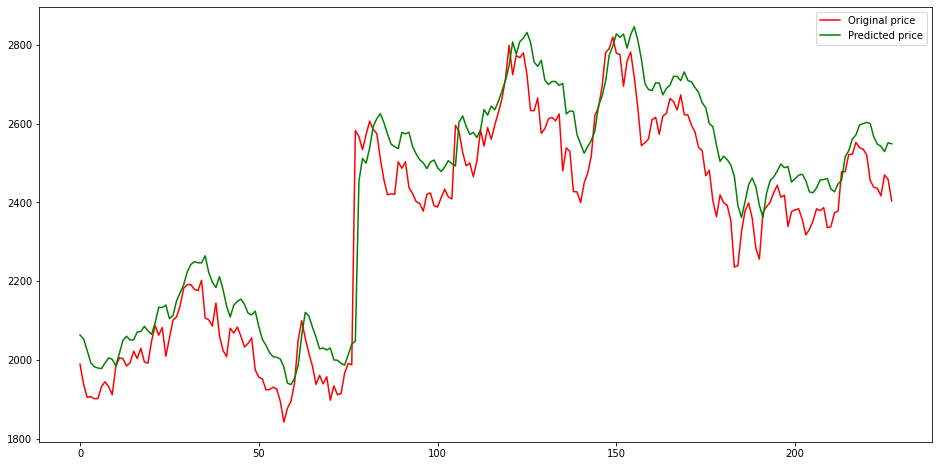

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#ffffff')
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictions, color='green', label='Predicted price')
plt.legend()

In [ ]:
out_frame = pd.DataFrame(y_test_scaled, columns=['Original'])
out_frame['Predictions'] = predictions
out_frame.head()

,Original,Predictions
0,1146.65,1179.823853
1,1134.50,1159.060791
2,1142.50,1143.682861
3,1147.15,1138.965088
4,1136.05,1142.818481


In [ ]:
out_frame.to_csv("predictions.csv")

In [ ]:
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
new_test = np.array([[1465.00,1445.00,1464.85,1418.00,1409.00,1398.80,1403.00,1391.80,1391.25,1388.05,1382.20,1382.00,1359.15,1355.00,1340.00,1320.00,1331.40,1330.40,1344.00,1340.00,1320.45,1334.00,1328.10,1331.00,1290.10,1286.90,1345.00,1319.35,1299.00,1300.00,1290.00,1327.00,1337.00,1315.00,1334.00,1435.00,1449.00,1425.00,1448.25,1410.00,1410.00,1392.00,1400.00,1458.00,1486.00,1472.00,1470.00,1490.00,1456.00,1475.00]])

Stock prices from 16-May-2022 to 21-Jul-2022

In [ ]:
new_actual = np.array([[1465.00]])

In [ ]:
new_test

array([[1465.  , 1445.  , 1464.85, 1418.  , 1409.  , 1398.8 , 1403.  ,
        1391.8 , 1391.25, 1388.05, 1382.2 , 1382.  , 1359.15, 1355.  ,
        1340.  , 1320.  , 1331.4 , 1330.4 , 1344.  , 1340.  , 1320.45,
        1334.  , 1328.1 , 1331.  , 1290.1 , 1286.9 , 1345.  , 1319.35,
        1299.  , 1300.  , 1290.  , 1327.  , 1337.  , 1315.  , 1334.  ,
        1435.  , 1449.  , 1425.  , 1448.25, 1410.  , 1410.  , 1392.  ,
        1400.  , 1458.  , 1486.  , 1472.  , 1470.  , 1490.  , 1456.  ,
        1475.  ]])

In [ ]:
new_data_scaler = MinMaxScaler(feature_range=(0,1))
new_scaled_data = new_data_scaler.fit_transform(new_test)
new_scaled_actual = new_data_scaler.fit_transform(new_actual)

Now we will give these 50 days' prices to model and it will predict the opening price for 22-Jul-2022

In [ ]:
new_pred = model.predict(new_scaled_data)

In [ ]:
new_pred

array([[0.00311986]], dtype=float32)

In [ ]:
new_pred =  new_data_scaler.inverse_transform(new_pred)

In [ ]:
new_pred

array([[1465.0032]], dtype=float32)

Price predicted by the model is 1465.0026
Actual open price of the GRASIM stock was 1465.00